# Summary

This notebook conducts what's known as an *ETL* pipeline. ETL stand for *Extract-Transform-Load*. Data science projects almost always begin by deciding what data we need to conduct an analysis, what transformations need to be performed on the data, and how the data should be stored for efficient manipulation/joining.

In this notebook we will:
- Pull down several raw datasets contained on the [NHANES website](https://en.wikipedia.org/wiki/Hierarchical_Data_Format). We'll do this using a combination of bash and pandas: bash for the datasets that need to be unzipped, pandas for those we can read directly from source.
- Store the raw SAS format data as something more reasonable and modern (I'm going to use [HDF format](https://github.com/wesm/feather) which is a super fast binary data representation, but feel free to play around with .h5 or another format as you see fit)
- Do some initial QC checks on the data to ensure everything looks reasonable.

# Learning Objectives

After completing this module you should be able to do the following:

1. Use pandas to pull raw data from source
2. Use ```wget``` and ```unzip``` to pull in data that can't be read directly from source via pandas
3. Understand why data compression is important, and how to downcast datatypes for efficient memory allocation
4. Construct basic visualization tools for checking data quality
5. Understand what metadata is, and build some tools for efficiently binding data with metadata
6. Understand how to join together two relational tables

# Initialize

Below are the external dependencies this notebook depends on to function. If you don't have these installed you can install them using pip or conda- whichever you typically use as your package manager.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import utils # Utility functions we will use

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
pd.set_option('max.rows', 100)
pd.set_option('max.columns', 100)

In [4]:
data_dir = '/mnt/data0/data/nhanes/' # Change this location to the path where you would like your data saved to
python = '~/venv3/bin/python' # path to virtualenv
hdf_path = 'nhanes.h5' # Path to hdf store we will create later

# Download, unzip, and save raw physical activity monitor data.

The raw PAX data is zipped due to it's size and can't be read directly into pandas. We use the following steps to get it into a more manageable format:
1. Download the data using the bash command ```wget```
2. Unzip the downlaoded data using the bash command ```unzip```
3. Read the data into pandas, and downcast data types to save on memory. The machine we are using has 32G of RAM, if your machine has less you may have issues with this step. If that's the case we suggest you don't actually run this portion of the ETL pipeline but rather use the ```nhanes.h5``` store we have written out and supplied to you.

In [5]:
#####################################################################################################
# RUN THIS BLOCK ONLY IF YOU WANT TO RECREATE THE ETL PROCESS, OTHERWISE READ THE PREPROCESSED FILE #
#####################################################################################################

! wget wget https://wwwn.cdc.gov/Nchs/Nhanes/2005-2006/PAXRAW_D.ZIP
! mv PAXRAW_D.ZIP {data_dir}
! unzip {data_dir}PAXRAW_D.ZIP

--2018-03-14 21:01:53--  http://wget/
Resolving wget (wget)... failed: Name or service not known.
wget: unable to resolve host address ‘wget’
--2018-03-14 21:01:53--  https://wwwn.cdc.gov/Nchs/Nhanes/2005-2006/PAXRAW_D.ZIP
Resolving wwwn.cdc.gov (wwwn.cdc.gov)... 198.246.102.39
Connecting to wwwn.cdc.gov (wwwn.cdc.gov)|198.246.102.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 470990068 (449M) [application/x-zip-compressed]
Saving to: ‘PAXRAW_D.ZIP’

 1% [                                       ] 7,114,702   4.04MB/s             ^C
Archive:  /mnt/data0/data/nhanes/PAXRAW_D.ZIP
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /mnt/data0/data/nhanes/PAXRAW_D.ZIP or
        /mnt/data0/data/nhanes/PAXRAW_D.ZIP.z

In [4]:
# Here we are reading the SAS file we pulled down to local. By default SAS stores all columns as float, we want to downcast the data types into something
# less memory hungry.
pax_raw = pd.read_sas(os.path.join(data_dir, 'paxraw_d.xpt'))

In [5]:
# Using the default float types is extremely memory intensive given the number of rows we are dealing with. Let's downcast each column appropriately.

type_map = {
    'SEQN': np.int64,
    'PAXSTAT': np.int8,
    'PAXCAL': np.int8,
    'PAXDAY': np.int8,
    'PAXHOUR': np.int16,
    'PAXMINUT': np.int16,
    'PAXINTEN': np.int16,
    'PAXSTEP': np.float32,
    'PAXN': np.int16
    
}

# Note this function mutates in place and does not return a copy
def downcast_col_types(df, type_map):
    for c in df.columns:
        df[c] = df[c].astype(type_map[c])

In [6]:
downcast_col_types(pax_raw, type_map=type_map)

In [7]:
# pythonize column names
pax_raw.columns = [x.lower() for x in pax_raw.columns]

In [12]:
# Display dataframe types and usage statistics
pax_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74874095 entries, 0 to 74874094
Data columns (total 8 columns):
seqn             int64
paxstat          int8
paxcal           int8
paxday           int8
paxn             int16
paxinten         int16
paxstep          float32
minute_of_day    int16
dtypes: float32(1), int16(3), int64(1), int8(3)
memory usage: 1.5 GB


You can see that downcasting our types saved us a *significant* amount of memory. We manually inferred the best datatypes, but for datasets with larger numbers of columns it would be more efficient to automatically infer the datatypes.

We will store our data in an HDF store. An HDF store is very similar to a database like SQLite or PostGreSQL in that you can store several tables under one store. Additionally, HDF preserves python data types between write and read- which is a very nice property for dates or in our case memory savings. You can see in the code block below that we can list the table keys stored in our HDF store. Finally, I/O operations are *much* faster than file formats such as csv, sometimes by as much as 100x.

In [14]:
pax_raw.to_hdf(os.path.join(data_dir, hdf_path), 'pax_raw')

# Read other NHANES tables directly from source

The other tables aren't compressed- they are simply raw .XPT files written out via SAS. We can read directly from source. There are a TON of interesting files on the NHANES website- from disease state questionaires to physical activity questionaires. We have linked a few interesting tables below, we will leave it to you to add the rest.

In [6]:
# In order to grab tables from the CDC NHANES website, simply add a table alias to the dictionary below,
# and then reference the table link address as the corresponding key value. The read_sas_write_feather
# function in utils will then read each sas file and write it to write_dir in feather format using the alias as the file name

source_paths = {
    'medical_conditions_questionaire': 'https://wwwn.cdc.gov/Nchs/Nhanes/2005-2006/MCQ_D.XPT',
    'weight_history_questionaire': 'https://wwwn.cdc.gov/Nchs/Nhanes/2005-2006/WHQ_D.XPT',
    'demographics_with_sample_weights': 'https://wwwn.cdc.gov/Nchs/Nhanes/2005-2006/DEMO_D.XPT'
}

In order to optimize I/O, and keep all of our data in one place, we'll download each of the raw datasets we are interested in into memory, then save it to our already created HDF store.

In [7]:
utils.read_sas_write_hdf(source_paths, data_dir, 'nhanes.h5', downcast=False, verbose=False)

In [8]:
with pd.HDFStore(os.path.join(data_dir, 'nhanes.h5')) as hdf:
    print(hdf.keys())

['/demographics_with_sample_weights', '/medical_conditions_questionaire', '/pax_raw', '/physical_activity_individual_questionaire', '/physical_activity_questionaire', '/weight_history_questionaire']


Looks like all requested tables made it safely into our data store!

## Exercise 1: Find and read the physical activity questionnaire

Find the raw SAS file on the 2005-2006 NHANES website that corresponds to the physical activity questionnaire. Use the function ```read_sas_write_hdf()``` to download this file and write it into the HDF store that contains the other tables we already downloaded above.

## Exercise 1: Solution

In [9]:
append_paths = {
    'physical_activity_questionnaire': 'https://wwwn.cdc.gov/Nchs/Nhanes/2005-2006/PAQ_D.XPT'
}

In [ ]:
read_sas_write_hdf(source_paths, data_dir, 'nhanes.h5', downcast=False, verbose=False)

# Initial QC of physical activity data

In order to verify that the raw physical activity data looks reasonable, we will create a some tools that will allow us to quickly visualize the time series that correspond to each user-day's walking patterns. There are a few good reasons for doing this:
1. This will allow us to infer if our preprocessing worked correctly
2. It will allow us to identify idiosyncracies in the raw data itself
3. It will help us better understand what sorts of features could be useful for various prediction or infeence problems

In [10]:
pax_raw = pd.read_hdf(os.path.join(data_dir, hdf_path), 'pax_raw')

In [12]:
# Add a "minute of day" column as a plotting index
pax_raw['minute_of_day'] = pax_raw.paxhour*60 + pax_raw.paxminut

In [10]:
pax_raw.head()

,seqn,paxstat,paxcal,paxday,paxn,paxinten,paxstep,minute_of_day
0,31128,1,1,1,1,166,4.0,0
1,31128,1,1,1,2,27,0.0,1
2,31128,1,1,1,3,0,0.0,2
3,31128,1,1,1,4,276,4.0,3
4,31128,1,1,1,5,0,0.0,4


In [11]:
# Take the raw data and filter out a single person just to check if the data looks reasonable.
pax_sample = pax_raw[pax_raw.seqn==31128].copy()

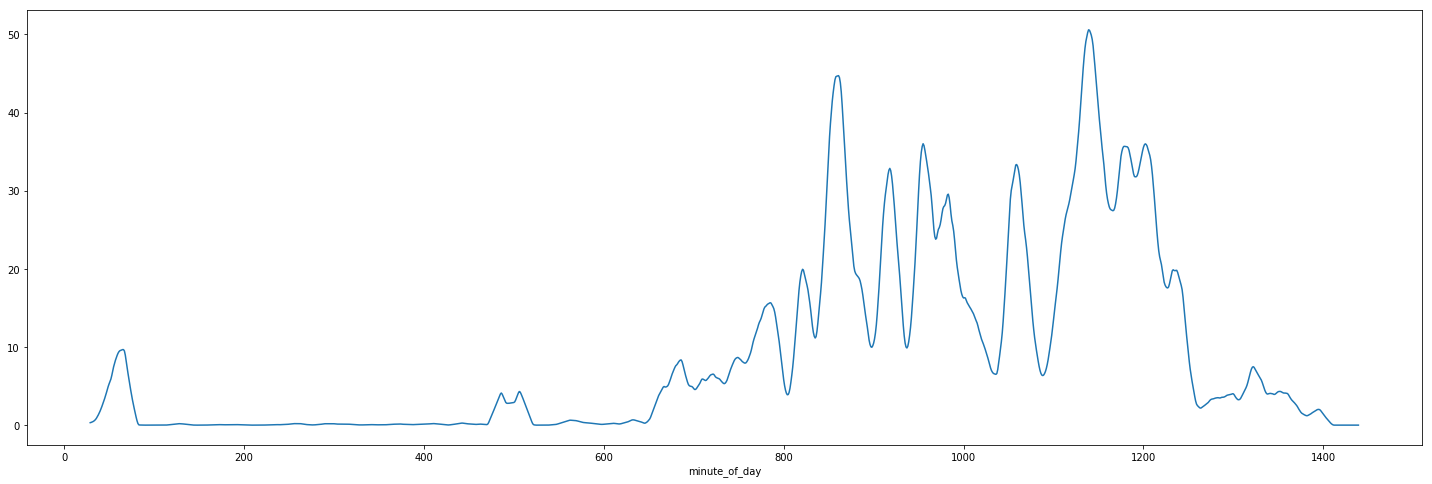

In [12]:
# Plot the 30-minute rolling walk step series for our sampled user over day 1
pax_sample[pax_sample.paxday==1].set_index('minute_of_day').paxstep.rolling(window=30, win_type='triang').mean().plot(figsize=(25,8))

We just did some hand coding to plot a sngle user-day, but what if we wanted to explore at *many* user days? It would be helpful to build a tool that would allow us to quickly look at different days and different users in our data.

## Exercise 2: Plotting user day series

Using the example code above, define a function ```plot_user_steps()``` that takes 4 arguments as input and plots a specific user's rolling walk step plot simialr to the plot shown above. The function's argument's should be:
1. ```pax_df``` The physical activity dataframe (pandas dataframe)
2. ```seqn_id``` The unique study participant id (int)
3. ```day_of_study``` (int) The day of the study to plot
4. ```window_len``` (int) The window length to use for the moving average.

The function should then plot the rolling walk series for a specific user, for a specific day. As a bonus, build in functionality so that passing ```None``` to the parameter ```seqn_id``` will default to choosing a random id from the set of seqn ids and using that to create the plot.

**Side Note: Building Data Science Tools**
A lot of what practicing data scientists do on a daily basis revolves around building tools that solve specific problems pertaining to an analysis. In fact, some may argue that's what seperates a data scientist from your everyday analyst. During this module we really want to encourage you to build tools that make analysis scale. In the process you may even find that it can be very fun and rewarding to create a useful suite of analysis tools to speed up your workflow!

## Exercise 2: Solution

We wrote a little snippet of code that implements the solution above. If you are curious how we did it, take a look in the ```utils``` folder that was imported at the top of the notebook.

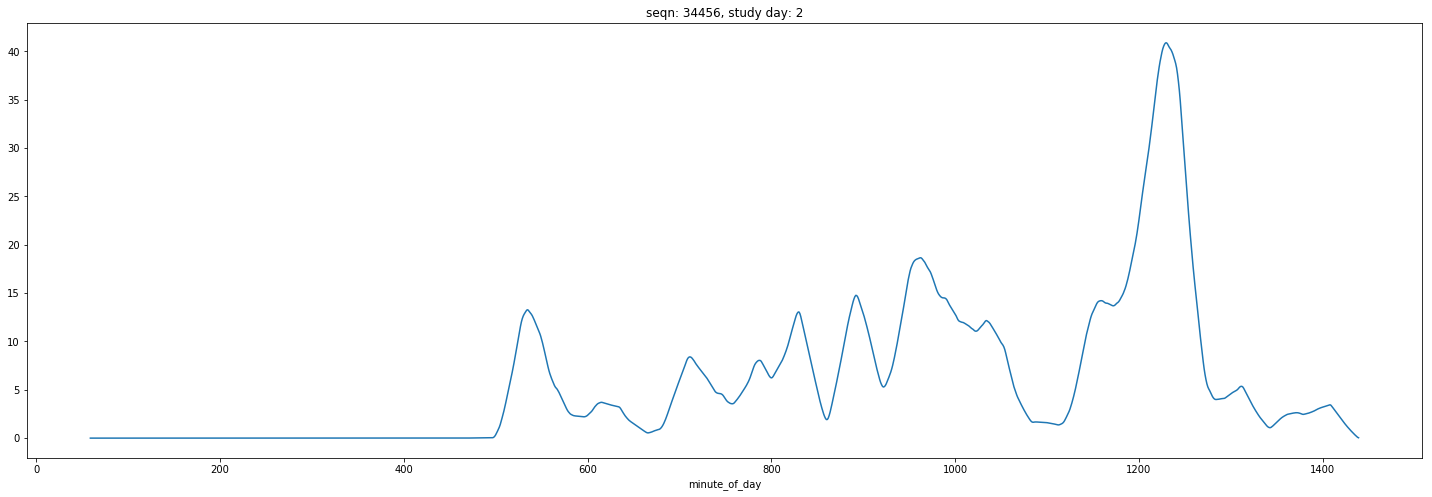

In [16]:
utils.plot_user_steps(pax_raw, None, 2, 60)

# Joining Data

The NHANES dataset has **A LOT** of tables. These tables are *relational* in structure meaning that their is a heirarchical structure that relates one set of data to another. In the NHANES dataset the *person level identifier* is the ```seqn``` number as you have already seen above. For some tables each row corresponds to exactly one ```seqn``` number. For other tables (like the raw activity data we have already worked with) there is a *one to many* mapping between ```seqn``` identifiers and row numbers, meaning that one ```seqn``` number corresponds to multiple input rows. Indeed for the ```pax_raw``` dataset we already worked with above each person is associated with *thousands* of rows corresponding to each minute of a day in which the person wore an activity monitor.

For this next section we will ensure that we can join together data from the various tables we pulled. This will be important for creating new interesting features later on, both for prediction and inference tasks, as we'll need to put together a feature matrix that combines data from multiple tables within the NHANES database.

## Example: Joining Datasets

As an example let's join together two of the tables we pulled in above that should now exist in your local HDF store:

- Participant demographics
- Physical activity data (we already pulled this in above)

There is a 1:1 correspondence between these two tables. For this join, we will do what is known as an *inner join*. This means that we will specify a join key that exists in both sets, and *only* join those keys that exist in the intersection of the two key sets. For more information on the different types of joins check out [this resource](https://www.w3schools.com/sql/sql_join.asp).

In [5]:
demo_df = pd.read_hdf(os.path.join(data_dir, hdf_path), 'demographics_with_sample_weights')

In [6]:
# Let's checkout what's in this dataframe
demo_df.head()

,seqn,sddsrvyr,ridstatr,ridexmon,riagendr,ridageyr,ridagemn,ridageex,ridreth1,dmqmilit,dmdborn,dmdcitzn,dmdyrsus,dmdeduc3,dmdeduc2,dmdschol,dmdmartl,dmdhhsiz,dmdfmsiz,indhhinc,indfminc,indfmpir,ridexprg,dmdhrgnd,dmdhrage,dmdhrbrn,dmdhredu,dmdhrmar,dmdhsedu,sialang,siaproxy,siaintrp,fialang,fiaproxy,fiaintrp,mialang,miaproxy,miaintrp,aialang,wtint2yr,wtmec2yr,sdmvpsu,sdmvstra
0,31127,4.0,2.0,2.0,1.0,5.397605e-79,11.0,12.0,3.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,4.0,4.0,4.0,4.0,0.75,NaN,2.0,21.0,1.0,3.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,6434.950248,6571.396373,2.0,44.0
1,31128,4.0,2.0,1.0,2.0,1.100000e+01,132.0,132.0,4.0,NaN,1.0,1.0,NaN,4.0,NaN,1.0,NaN,7.0,6.0,8.0,5.0,0.77,2.0,1.0,47.0,1.0,2.0,NaN,NaN,1.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,9081.700761,8987.041810,1.0,52.0
2,31129,4.0,2.0,2.0,1.0,1.500000e+01,189.0,190.0,4.0,NaN,1.0,1.0,NaN,10.0,NaN,1.0,5.0,6.0,6.0,10.0,10.0,2.71,NaN,1.0,41.0,1.0,4.0,1.0,4.0,1.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,5316.895215,5586.719481,1.0,51.0
3,31130,4.0,2.0,2.0,2.0,8.500000e+01,NaN,NaN,3.0,2.0,1.0,1.0,NaN,NaN,4.0,NaN,2.0,1.0,1.0,4.0,4.0,1.99,NaN,2.0,85.0,1.0,4.0,2.0,NaN,1.0,2.0,2.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,29960.839509,34030.994786,2.0,46.0
4,31131,4.0,2.0,2.0,2.0,4.400000e+01,535.0,536.0,4.0,2.0,1.0,1.0,NaN,NaN,4.0,NaN,1.0,4.0,4.0,11.0,11.0,4.65,2.0,1.0,36.0,1.0,5.0,1.0,4.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,26457.708180,26770.584605,1.0,48.0


What in the world? What are all the cryptic column names?? Well, the CDC has chosen somewhat unhelpful names that map to demographic characteristics of participants. We *could* go to the website that lists the variable names and keep track of them. However, if we are clever there might be a better way. . . .The pandas library makes it esy to scrape tables via a url. All we need is the url where the table is located, as well as the index of the xml blob we are interested in.

In [9]:
demo_metadata_url = 'https://wwwn.cdc.gov/nchs/nhanes/search/variablelist.aspx?Component=Demographics&CycleBeginYear=2005'
idx = 1 # I looked up the blob I was interested in in advance

In [10]:
demo_metadata = pd.read_html(demo_metadata_url)[idx]

In [13]:
demo_metadata.head()

,Variable Name,Variable Description,Data File Name,Data File Description,Begin Year,EndYear,Component,Use Constraints
0,SEQN,Respondent sequence number.,CDEMO_AD,California - Demographic Variables & Sample We...,1999,2006,Demographics,RDC Only
1,RIDSTATR,Interview and examination status of the partic...,CDEMO_AD,California - Demographic Variables & Sample We...,1999,2006,Demographics,RDC Only
2,RIAGENDR,Gender of the participant.,CDEMO_AD,California - Demographic Variables & Sample We...,1999,2006,Demographics,RDC Only
3,RIDAGEYR,Age in years of the participant at the time of...,CDEMO_AD,California - Demographic Variables & Sample We...,1999,2006,Demographics,RDC Only
4,RIDAGEMN,Age in months of the participant at the time o...,CDEMO_AD,California - Demographic Variables & Sample We...,1999,2006,Demographics,RDC Only


Nice! Now we have a dataframe with two columns of interest: ```Variable Name``` and ```Variable Description```. We could remap the column names to human readable. I'll leave that as an exercise for you if you feel inclined.

## Exercise: Create questionaire metadata table

For this exercise replicate the process we did above for the questionaire metadata. You will need:
- The url on the 2005 NHANES website where the questionaire metadata is stored
- The index of the xml blob corresponding to the metadata table

Save the metadata table in a new dataframe called ```quest_metadata```.

In [14]:
quest_metadata_url = 'https://wwwn.cdc.gov/nchs/nhanes/search/variablelist.aspx?Component=Questionnaire&CycleBeginYear=2005'

In [17]:
quest_meta_data = pd.read_html(quest_metadata_url)[idx]

In [18]:
quest_meta_data

,Variable Name,Variable Description,Data File Name,Data File Description,Begin Year,EndYear,Component,Use Constraints
0,SEQN,Respondent sequence number.,ACQ_D,Acculturation,2005,2006,Questionnaire,None
1,ACD010A,What language(s) {do you/does SP} usually spea...,ACQ_D,Acculturation,2005,2006,Questionnaire,None
2,ACD010B,What language(s) {do you/does SP} usually spea...,ACQ_D,Acculturation,2005,2006,Questionnaire,None
3,ACD010C,What language(s) {do you/does SP} usually spea...,ACQ_D,Acculturation,2005,2006,Questionnaire,None
4,ACD040,Now I'm going to ask you about language use. W...,ACQ_D,Acculturation,2005,2006,Questionnaire,None
5,SEQN,Respondent sequence number.,ALQ_D,Alcohol Use,2005,2006,Questionnaire,None
6,ALQ101,The next questions are about drinking alcoholi...,ALQ_D,Alcohol Use,2005,2006,Questionnaire,None
7,ALQ110,"In {your/SP's} entire life, {have you/has he/ ...",ALQ_D,Alcohol Use,2005,2006,Questionnaire,None
8,ALQ120Q,"In the past 12 months, how often did {you/SP} ...",ALQ_D,Alcohol Use,2005,2006,Questionnaire,None
9,ALQ120U,UNIT OF MEASURE.,ALQ_D,Alcohol Use,2005,2006,Questionnaire,None
